## Ex-04

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

### Task 1

#### 1.1

In [2]:
def simulate_sir_simple(lam, mu, I0, T, N):
    X = [] # observations
    C = [] # states

    I = I0 # number of infected individuals
    R = 0 # number of recovered individuals
    S = N - I - R # number of susceptible individuals

    for t in range(T):
        C.append((S, I, R))

        dS = -lam * S * I / N
        dI = lam * S * I / N - (mu * I)
        dR = mu * I

        # for T+1
        S_next = S + dS
        I_next = I + dI
        R_next = R + dR

        dS = S - S_next
        dR = R_next - R

        X.append((dS, dR))

        S,I,R = S_next, I_next, R_next
    
    return np.array(X), np.array(C)

#### 1.2

In [3]:
def explore_prior(N, T, lam_list, mu_list, I0_list):
    fig, axes = plt.subplots(len(lam_list), len(mu_list), figsize=(15, 15), sharex=True, sharey=True)
    for i, lam in enumerate(lam_list):
        for j, mu in enumerate(mu_list):
            for I0 in I0_list:
                _, states = simulate_sir_simple(lam, mu, I0, T, N)
                
                S,I,R = zip(*states)
                S, I, R = np.array(S), np.array(I), np.array(R)

                ax=axes[i, j]
                ax.plot(range(T), S, label=f'S(t), I0={I0}')
                ax.plot(range(T), I, label=f'I(t), I0={I0}')
                ax.plot(range(T), R, label=f'R(t), I0={I0}')
                ax.set_title(f'λ={lam}, μ={mu}')
                ax.set_xlabel('days')
                ax.set_ylabel('population')

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(I0_list))
    plt.tight_layout()
    plt.show()

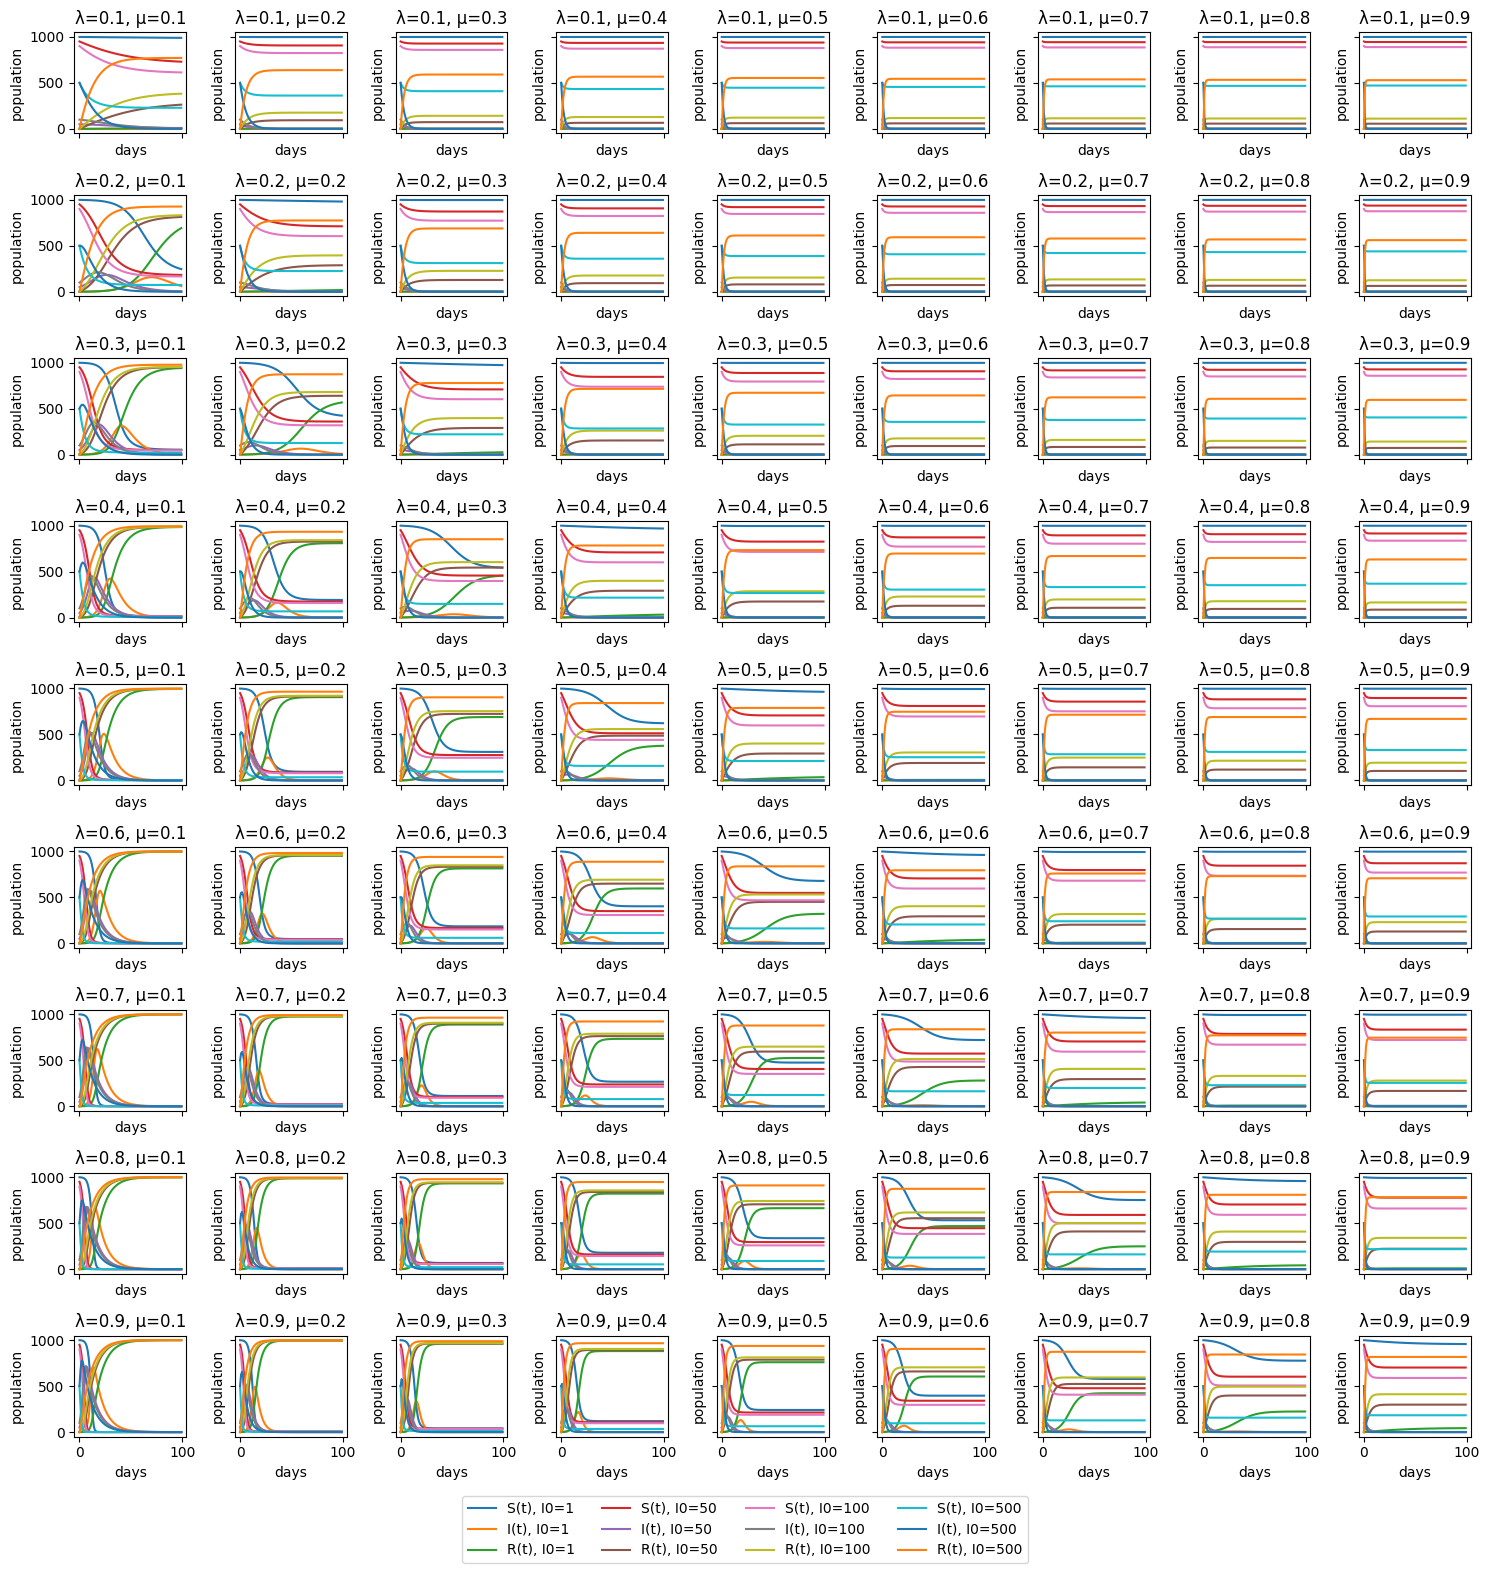

In [4]:
N = 1000
T = 100

# hyperparameters
lam_list = np.round(np.linspace(0.1, 0.9, 9),1)
mu_list = np.round(np.linspace(0.1, 0.9, 9),1)
I0_list =  [1, 50, 100, 500]

explore_prior(N, T, lam_list, mu_list, I0_list)



With range
* lambda = [0.2, 0.9]
* mu = [0.1, 0.7]
* I_0 = [1, 100]
  
the most diverse dynamics are observed.

#### 1.3

In [5]:
def generate_sir_data(num_samples, T, N):
    data = []
    target = []

    for _ in range(num_samples):
        lam = np.random.uniform(0.2, 0.9)
        mu = np.random.uniform(0.1, 0.7)
        I0 = np.random.randint(1,100)

        X, _ = simulate_sir_simple(lam, mu, I0, T, N)

        data.append(X.flatten())
        target.append([lam, mu, I0])

    return np.array(data), np.array(target)

class SIRDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.Y[i]
    
class SIRModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SIRModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.network(x)

In [6]:
def train_model(model, criterion, optimizer, data_loader, epochs):
    model.train()
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        for x_batch, y_batch in data_loader:
            optimizer.zero_grad()
            
            output = model(x_batch)
            
            loss = criterion(output, y_batch)
            loss.backward()
            
            optimizer.step()
            epoch_loss += loss.item()
        losses.append(epoch_loss/len(data_loader))
        
        if epoch % 5 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {losses[-1]:.4f}')
    return losses

def test_model(model, dataloader):
    model.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            outputs = model(x_batch)

            preds.append(np.array(outputs))
            targets.append(np.array(y_batch))
    
    return np.vstack(preds), np.vstack(targets)

Training mode ...
Epoch 1/50, Loss: 219.7328
Epoch 6/50, Loss: 12.9031
Epoch 11/50, Loss: 2.3293
Epoch 16/50, Loss: 0.7116
Epoch 21/50, Loss: 0.3294
Epoch 26/50, Loss: 0.2540
Epoch 31/50, Loss: 0.1763
Epoch 36/50, Loss: 0.5235
Epoch 41/50, Loss: 0.1386
Epoch 46/50, Loss: 0.1347


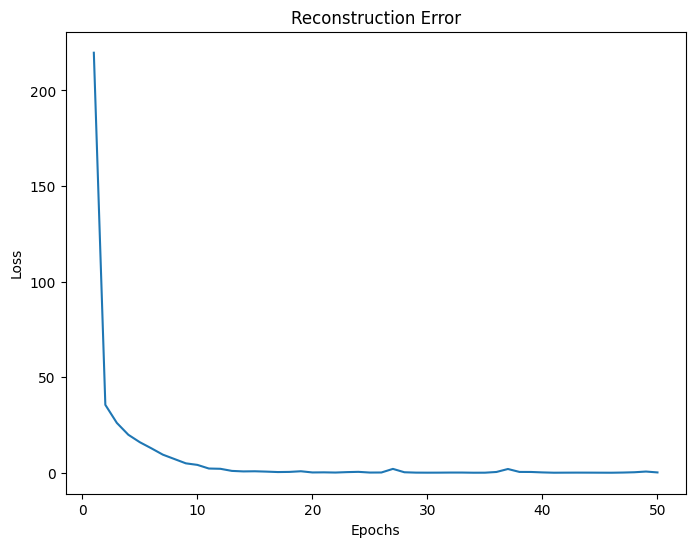

Test mode ...


/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_46947/4015364856.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  preds.append(np.array(outputs))
/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_46947/4015364856.py:31: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  targets.append(np.array(y_batch))


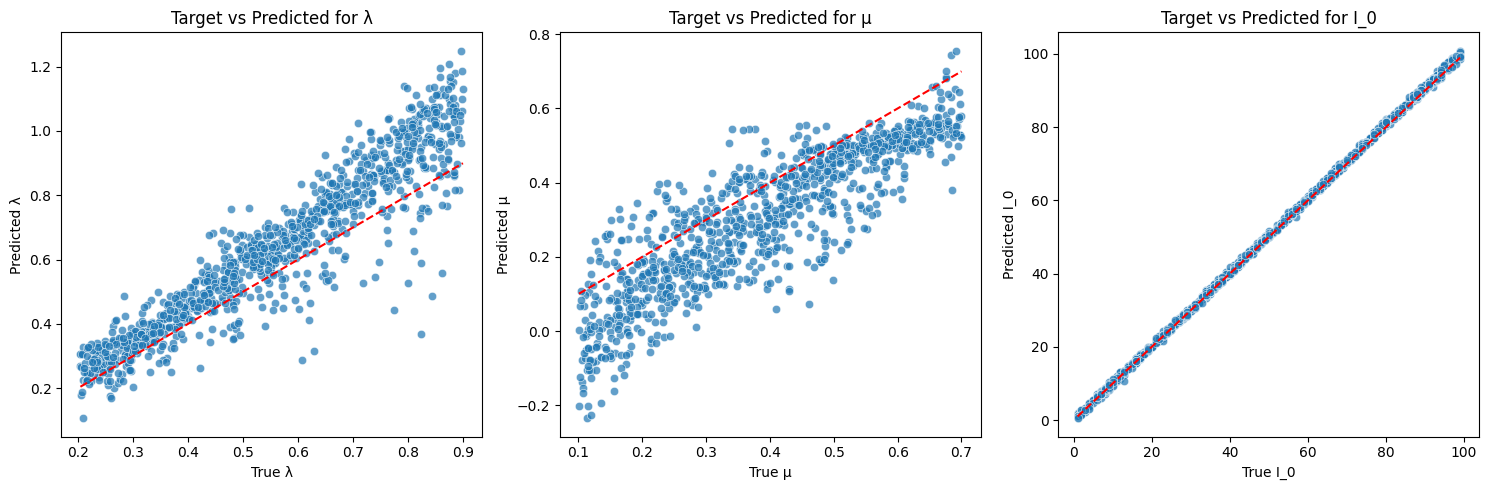

In [7]:
# hyperparameters
N = 1000
T = 100
num_samples = 5000
test_samples = 1000
input_size = T*2 # flattened SIR
hidden_size = 128
output_size = 3 # [lam, mu, I0]
batch_size = 64
lr = 0.001
epochs = 50

# generate data
x_train, y_train = generate_sir_data(num_samples, T, N)
x_test, y_test = generate_sir_data(num_samples=test_samples, T=T, N=N)

# preprocess data
train_dataset = SIRDataset(x_train, y_train)
test_dataset = SIRDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# initialize model
model = SIRModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# train model
print('Training mode ...')
train_loss = train_model(model, criterion, optimizer, train_loader, epochs)

# visualize training loss
plt.figure(figsize=(8,6))
sns.lineplot(x=np.arange(1, epochs+1), y=train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Reconstruction Error')
plt.show()

#test model
print('Test mode ...')
preds, targets = test_model(model, test_loader)

# visualize predictions vs targets
cols = ['λ', 'μ', 'I_0']
pred_df = pd.DataFrame(preds, columns=cols)
target_df = pd.DataFrame(targets, columns=cols)

fig, axes = plt.subplots(1, 3, figsize=(15,5))
for i, param in enumerate(cols):
        sns.scatterplot(x=target_df[param], y=pred_df[param], alpha=0.7, ax=axes[i])
        axes[i].plot([target_df[param].min(), target_df[param].max()],
                     [target_df[param].min(), target_df[param].max()],
                     color='red', linestyle='--')
        axes[i].set_xlabel(f'True {param}')
        axes[i].set_ylabel(f'Predicted {param}')
        axes[i].set_title(f'Target vs Predicted for {param}')
plt.tight_layout()
plt.show()


#### 1.4

In [8]:
# Conditional realNVP components
class ConditionalCouplingLayer(nn.Module):
    def __init__(self, input_size, condition_size, hidden_size):
        super(ConditionalCouplingLayer, self).__init__()
        self.split1 = input_size // 2
        self.split2 = input_size - self.split1

        self.subnet = nn.Sequential(
            nn.Linear(self.split1 + condition_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2 * self.split2),
        )

    def forward(self, x, cond):
        x1, x2 = x[..., :self.split1], x[..., self.split1:]
        params = self.subnet(torch.cat([x1, cond], dim=-1))
        s, t = params[..., :self.split2], params[..., self.split2:]
        s = torch.tanh(s)

        log_jacob_det = torch.sum(s, dim=-1)

        x2 = torch.exp(s) * x2 + t
        return torch.cat([x1, x2], dim=-1), log_jacob_det


    def reverse(self, x, cond):
        x1, x2 = x[..., :self.split1], x[..., self.split1:]
        params = self.subnet(torch.cat([x1, cond], dim=-1))
        s, t = params[..., :self.split2], params[..., self.split2:]
        s = torch.tanh(s)

        x2 = (x2 - t) * torch.exp(-s)
        return torch.cat([x1, x2], dim=-1)

class ConditionalrealNVP(nn.Module):
    def __init__(self, input_size, condition_size, hidden_size, n_layers):
        super(ConditionalrealNVP, self).__init__()
        self.layers = nn.ModuleList([
            ConditionalCouplingLayer(input_size, condition_size, hidden_size) for _ in range(n_layers)
        ])

    def forward(self, x, context):
        log_det_jacobian = 0
        for layer in self.layers:
            x, ldj = layer(x, context)
            log_det_jacobian += ldj
        return x, log_det_jacobian

    def reverse(self, z, context):
        for layer in reversed(self.layers):
            z = layer.reverse(z, context)
        return z

In [9]:
def train_realNVP(feature_extractor, realNVP, optimizer, data_loader, epochs):
    feature_extractor.train()
    realNVP.train()
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        for x_batch, y_batch in data_loader:
            optimizer.zero_grad()

            context = feature_extractor(x_batch)
            z, log_det_jacobian = realNVP(y_batch, context)
            
            nll = 0.5 * torch.sum(z**2, dim=1) - log_det_jacobian
            loss = torch.mean(nll)
            loss.backward()
            
            optimizer.step()
            epoch_loss += loss.item()
        
        losses.append(epoch_loss/len(data_loader))

        if epoch % 2 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {losses[-1]:.4f}')
    
    return np.array(losses)

def test_realNVP(feature_extractor, realNVP, data_loader):
    feature_extractor.eval()
    realNVP.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            context = feature_extractor(x_batch)
            outputs = realNVP.reverse(torch.randn_like(y_batch), context)

            preds.append(np.array(outputs))
            targets.append(np.array(y_batch))
    
    return np.vstack(preds), np.vstack(targets)


Training mode ...
Epoch 1/50, Loss: 117.1598
Epoch 3/50, Loss: 1.4336
Epoch 5/50, Loss: 0.9437
Epoch 7/50, Loss: 0.5523
Epoch 9/50, Loss: 0.1242
Epoch 11/50, Loss: -0.0989
Epoch 13/50, Loss: -0.1544
Epoch 15/50, Loss: -0.1826
Epoch 17/50, Loss: -0.2264
Epoch 19/50, Loss: -0.3239
Epoch 21/50, Loss: -0.2715
Epoch 23/50, Loss: -0.4908
Epoch 25/50, Loss: -0.6299
Epoch 27/50, Loss: -0.7180
Epoch 29/50, Loss: -0.6717
Epoch 31/50, Loss: -0.6133
Epoch 33/50, Loss: -0.6830
Epoch 35/50, Loss: -0.7312
Epoch 37/50, Loss: -0.8443
Epoch 39/50, Loss: -0.4568
Epoch 41/50, Loss: -0.8484
Epoch 43/50, Loss: -0.5520
Epoch 45/50, Loss: -1.0047
Epoch 47/50, Loss: -0.7924
Epoch 49/50, Loss: -1.0741


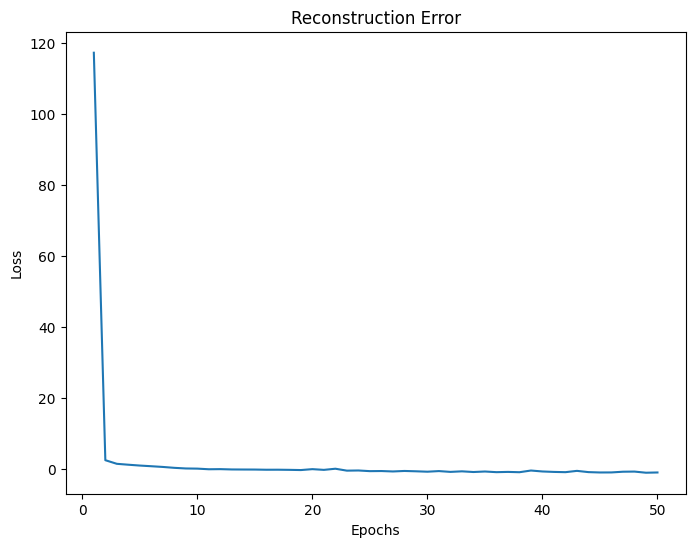

Test mode ...


/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_46947/443406207.py:37: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  preds.append(np.array(outputs))
/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_46947/443406207.py:38: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  targets.append(np.array(y_batch))


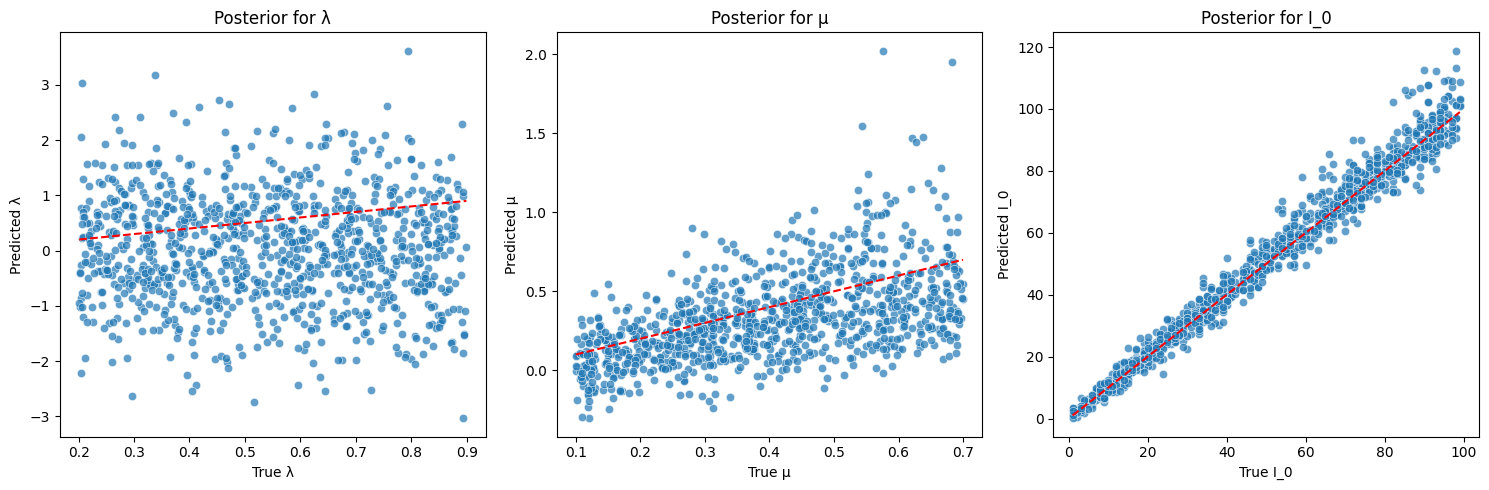

In [10]:
# Hyperparameters
T = 100
N = 1000
num_samples = 5000
test_samples = 1000
input_size = T*2 # Flattened (dS, dR)
hidden_size = 64
batch_size = 64
lr = 0.001
epochs = 50
n_layers=2


# generate data
x_train, y_train = generate_sir_data(num_samples, T, N)
x_test, y_test = generate_sir_data(num_samples=test_samples, T=T, N=N)

# preprocess data
train_dataset = SIRDataset(x_train, y_train)
test_dataset = SIRDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize feature extractor and realNVP
feature_extractor = SIRModel(input_size, hidden_size, hidden_size)
realNVP = ConditionalrealNVP(input_size=3, condition_size=hidden_size, hidden_size=hidden_size, n_layers=n_layers)

# Define optimizer
params = list(feature_extractor.parameters()) + list(realNVP.parameters())
optimizer = optim.Adam(params, lr=lr)

# train model
print('Training mode ...')
train_loss = train_realNVP(feature_extractor, realNVP, optimizer, train_loader, epochs)

# visualize training loss
plt.figure(figsize=(8,6))
sns.lineplot(x=np.arange(1, epochs+1), y=train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Reconstruction Error')
plt.show()

# test model
print('Test mode ...')
preds, targets = test_realNVP(feature_extractor, realNVP, test_loader)

# visualize predictions vs targets
cols = ['λ', 'μ', 'I_0']
pred_df = pd.DataFrame(preds, columns=cols)
target_df = pd.DataFrame(targets, columns=cols)

fig, axes = plt.subplots(1, 3, figsize=(15,5))
for i, param in enumerate(cols):
    sns.scatterplot(x=target_df[param], y=pred_df[param], alpha=0.7, ax=axes[i])
    axes[i].plot([target_df[param].min(), target_df[param].max()],
                 [target_df[param].min(), target_df[param].max()],
                 color='red', linestyle='--')
    axes[i].set_xlabel(f'True {param}')
    axes[i].set_ylabel(f'Predicted {param}')
    axes[i].set_title(f'Posterior for {param}')
plt.tight_layout()
plt.show()


#### 1.5

In [11]:
def generate_posterior_samples(feature_extractor, realNVP, test_loader, num_preds, input_size):

    feature_extractor.eval()
    realNVP.eval()

    all_samples = []
    all_targets = []

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(next(feature_extractor.parameters()).device)
            context = feature_extractor(x)

            samples = []
            for _ in range(num_preds):
                z = torch.randn((x.size(0), input_size), device=context.device)  # Sampling from prior
                sample = realNVP.reverse(z, context)
                samples.append(sample.cpu().numpy())

            all_samples.append(np.stack(samples, axis=0))
            all_targets.append(y.numpy())

    preds = np.concatenate(all_samples, axis=1)  # Shape: (M, len(test_data), num_params)
    targets = np.concatenate(all_targets, axis=0)  # Shape: (len(test_data), num_params)

    return preds, targets

def compute_energy(y_samples, targets):
    
    targets = targets[None, :, :]  # Broadcast for M samples
    energy = -0.5 * np.sum((y_samples - targets) ** 2, axis=-1)  # Gaussian assumption
    return energy

def plot_posterior_distributions(samples, params):

    fig, axes = plt.subplots(2, len(params), figsize=(15, 5))
    for i, param in enumerate(params):
        param_samples = samples[:, :, i].flatten()

        axes[0,i].hist(param_samples, bins=30, density=True, alpha=0.5, label='Posterior Samples')
        axes[0,i].set_title(f'Posterior Histogram - {param}')
        axes[0,i].set_xlabel('Value')
        axes[0,i].set_ylabel('Density')
        axes[0,i].legend()

        # Empirical CDF
        ecdf = np.sort(param_samples)
        axes[1,i].plot(ecdf, np.linspace(0, 1, len(ecdf)), label='Empirical CDF', lw=2)
        axes[1,i].set_title(f'Empirical CDF - {param}')
        axes[1,i].set_xlabel('Value')
        axes[1,i].set_ylabel('Cumulative Probability')
        axes[1,i].legend()

    plt.tight_layout()
    plt.show()

def plot_joint_distribution(samples, params):

    joint_samples = samples.reshape(-1, samples.shape[-1])  # Shape: (M * len(X), num_params)
    df = pd.DataFrame(joint_samples, columns=params)

    sns.pairplot(df, diag_kind='kde', plot_kws={'s': 1, 'alpha':0.5}, corner=True)
    plt.suptitle('Joint Posterior Distribution', y=1)
    plt.show()

Mean Energy Score: -12.1479
Standard Deviation of Energy Scores: 29.4229


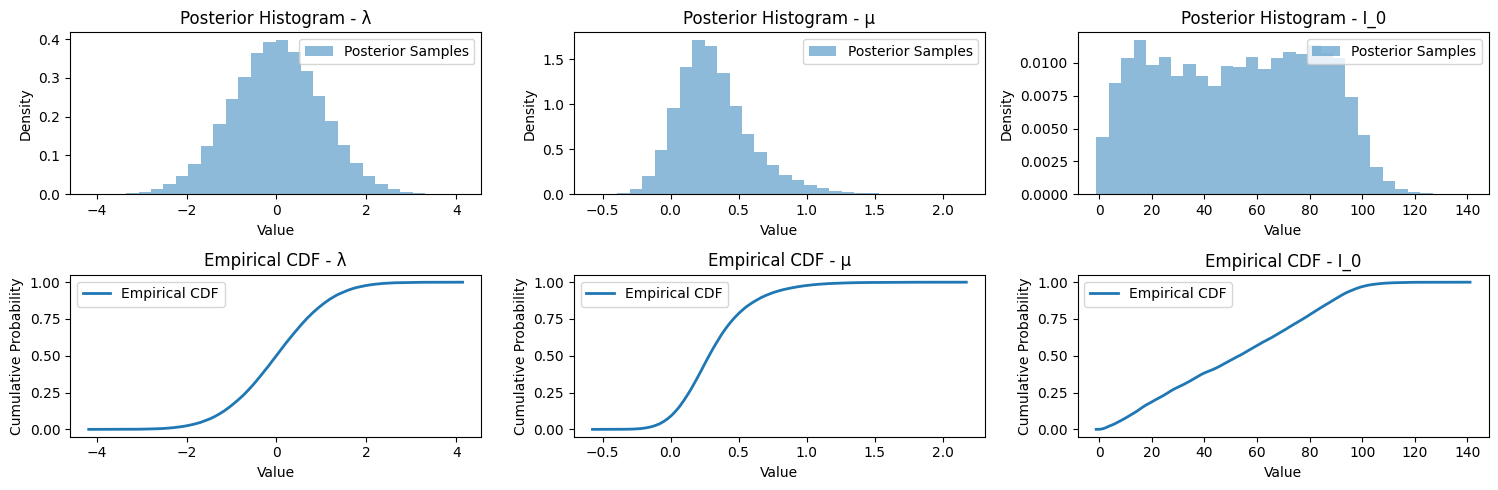

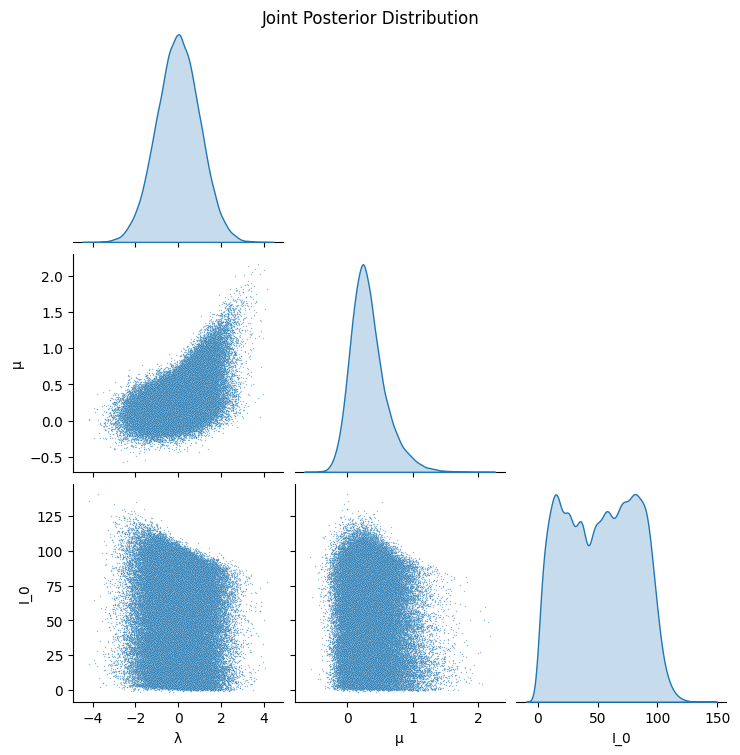

In [12]:
num_preds = 100
input_size = 3
params = ['λ', 'μ', 'I_0']

preds, targets = generate_posterior_samples(feature_extractor, realNVP, test_loader, num_preds, input_size)

energy_scores = compute_energy(preds, targets)

# displaying summarized energy scores
print(f'Mean Energy Score: {np.mean(energy_scores):.4f}')
print(f'Standard Deviation of Energy Scores: {np.std(energy_scores):.4f}')

# marginal distributions
plot_posterior_distributions(preds, params)

# joint distributions
plot_joint_distribution(preds, params)


### 1.6

In [13]:
def plot_confidence_intervals(resimulated_outcomes, true_simulated_outcomes, coverage):

    lower_bound = np.percentile(resimulated_outcomes, 2.5, axis=0)
    upper_bound = np.percentile(resimulated_outcomes, 97.5, axis=0)
    
    params = ['dS', 'dR']

    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
    for i, param in enumerate(params):
        axes[i].fill_between(range(len(lower_bound)), lower_bound[:, i], upper_bound[:, i], color='skyblue', alpha=0.5, label='95% CI')
        axes[i].plot(true_simulated_outcomes[:, i], 'o', color='orange', label='True Outcomes')
        axes[i].set_xlabel('samples')
        axes[i].set_ylabel(f'{param}')
        axes[i].legend()
    plt.suptitle(f'Posterior Predictive Calibration with coverage = {coverage}')
    plt.tight_layout()
    plt.show()

In [14]:
def posterior_predictive_calibration(posterior_samples, simulate_sir_simple, true_outcomes, T, N):

    M = posterior_samples.shape[0]

    resimulated_outcomes = []

    # simulate outcomes for predicted samples
    for k in range(M):
        current_outcomes = []
        for lam, mu, I0 in posterior_samples[k]:
            X, _ = simulate_sir_simple(lam, mu, I0, T, N)
            current_outcomes.append(np.sum(X, axis=0))
        resimulated_outcomes.append(np.stack(current_outcomes, axis=0))

    resimulated_outcomes = np.stack(resimulated_outcomes, axis=0)

    # simulate outcomes for true samples
    true_simulated_outcomes = []
    for lam, mu, I0 in true_outcomes:
        X, _ = simulate_sir_simple(lam, mu, I0, T, N)
        true_simulated_outcomes.append(np.sum(X, axis=0))

    true_simulated_outcomes = np.stack(true_simulated_outcomes, axis=0)

    # confidence intervals from predicted simulations
    lower_bound = np.percentile(resimulated_outcomes, 2.5, axis=0)
    upper_bound = np.percentile(resimulated_outcomes, 97.5, axis=0)

    # Check if true simulated outcomes are within confidence intervals
    true_within_interval = np.logical_and(true_simulated_outcomes >= lower_bound, true_simulated_outcomes <= upper_bound)

    # coverage as the proportion of observations within intervals
    coverage = np.mean(np.all(true_within_interval, axis=1))

    plot_confidence_intervals(resimulated_outcomes, true_simulated_outcomes, coverage)
    
    
    return coverage


/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_46947/1062177979.py:12: RuntimeWarning: overflow encountered in scalar multiply
  dS = -lam * S * I / N
/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_46947/1062177979.py:13: RuntimeWarning: overflow encountered in scalar multiply
  dI = lam * S * I / N - (mu * I)
/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_46947/1062177979.py:21: RuntimeWarning: invalid value encountered in scalar subtract
  dS = S - S_next
/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_46947/1062177979.py:22: RuntimeWarning: invalid value encountered in scalar subtract
  dR = R_next - R
/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_46947/1062177979.py:13: RuntimeWarning: invalid value encountered in scalar subtract
  dI = lam * S * I / N - (mu * I)


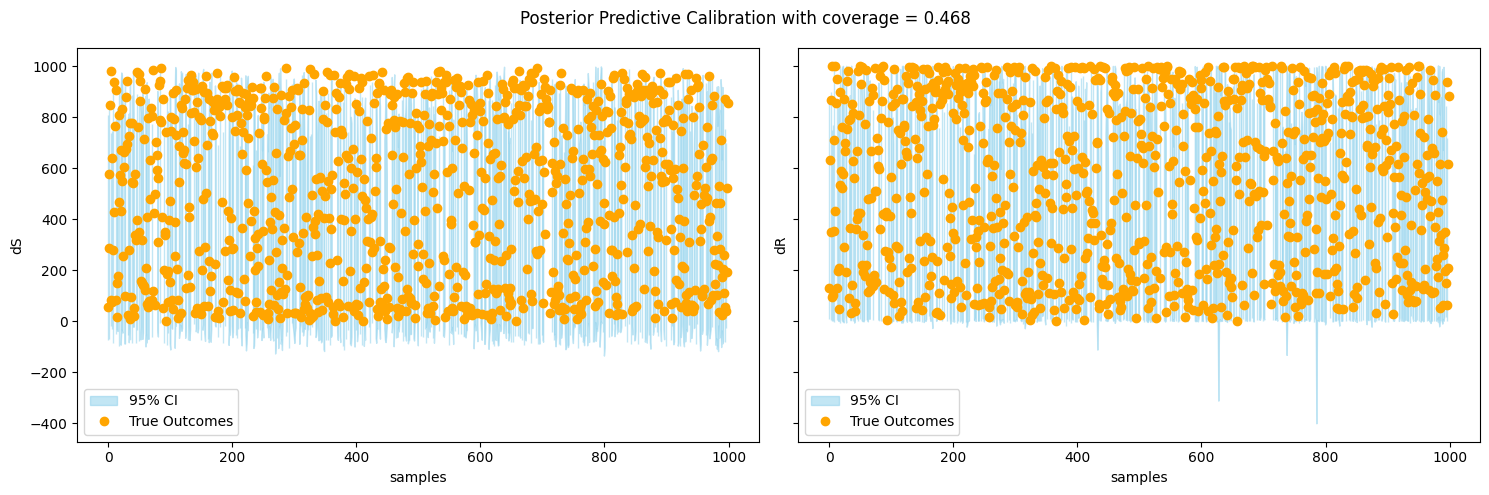

np.float64(0.468)

In [15]:
posterior_predictive_calibration(preds, simulate_sir_simple, y_test, T, N)


### Task 2

#### 2.1

In [16]:
import numpy as np

def simulate_sir_noisy(lam, mu, I0, L, rho, sigma2, T, N):

    X, C = simulate_sir_simple(lam, mu, I0, T, N)

    # multiplicative Gaussian noise
    ep_S = np.random.normal(rho, np.sqrt(sigma2), T)
    ep_I = np.random.normal(rho, np.sqrt(sigma2), T)
    ep_R = np.random.normal(rho, np.sqrt(sigma2), T)

    dS, dR = X[:, 0]*ep_S, X[:, 1]*ep_R
    S, I, R = C[:,0]*ep_S, C[:,1]*ep_I, C[:,2]*ep_R

    X = np.stack([dS, dR], axis=1)
    C = np.stack([S, I, R], axis=1)

    X_shifted = np.roll(X, int(L), axis=0)
    C_shifted = np.roll(C, int(L), axis=0)

    return X_shifted, C_shifted


In [17]:
def explore_noisy_prior(lam, mu, I0, N, T, L_list, rho_list, sigma_list):
    fig, axes = plt.subplots(len(rho_list), len(sigma_list), figsize=(15, 15), sharex=True, sharey=True)
    for i, rho in enumerate(rho_list):
        for j, sigma2 in enumerate(sigma_list):
            for L in L_list:
                sim, _ = simulate_sir_noisy(lam, mu, I0, L, rho, sigma2, T, N)
                
                S, R = zip(*sim)
                S, R = np.array(S), np.array(R)

                ax=axes[i, j]
                ax.plot(range(T), S, label=f'S(t), L={L}', linewidth=0.5)
                ax.plot(range(T), R, label=f'R(t), L={L}', linewidth=0.5)
                ax.set_title(f'ρ={rho}, σ2={sigma2}')
                ax.set_xlabel('days')
                ax.set_ylabel('value')

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(L_list))
    plt.tight_layout()
    plt.show()


In [18]:
lam=0.4
mu=0.2
I0=1
N = 1000
T = 100

# hyperparameters
rho_list = np.round(np.linspace(0.1, 0.9, 9), 1)
sigma_list = np.round(np.linspace(0.1, 0.9, 9), 1)
L_list =  np.linspace(0, 10, 2)

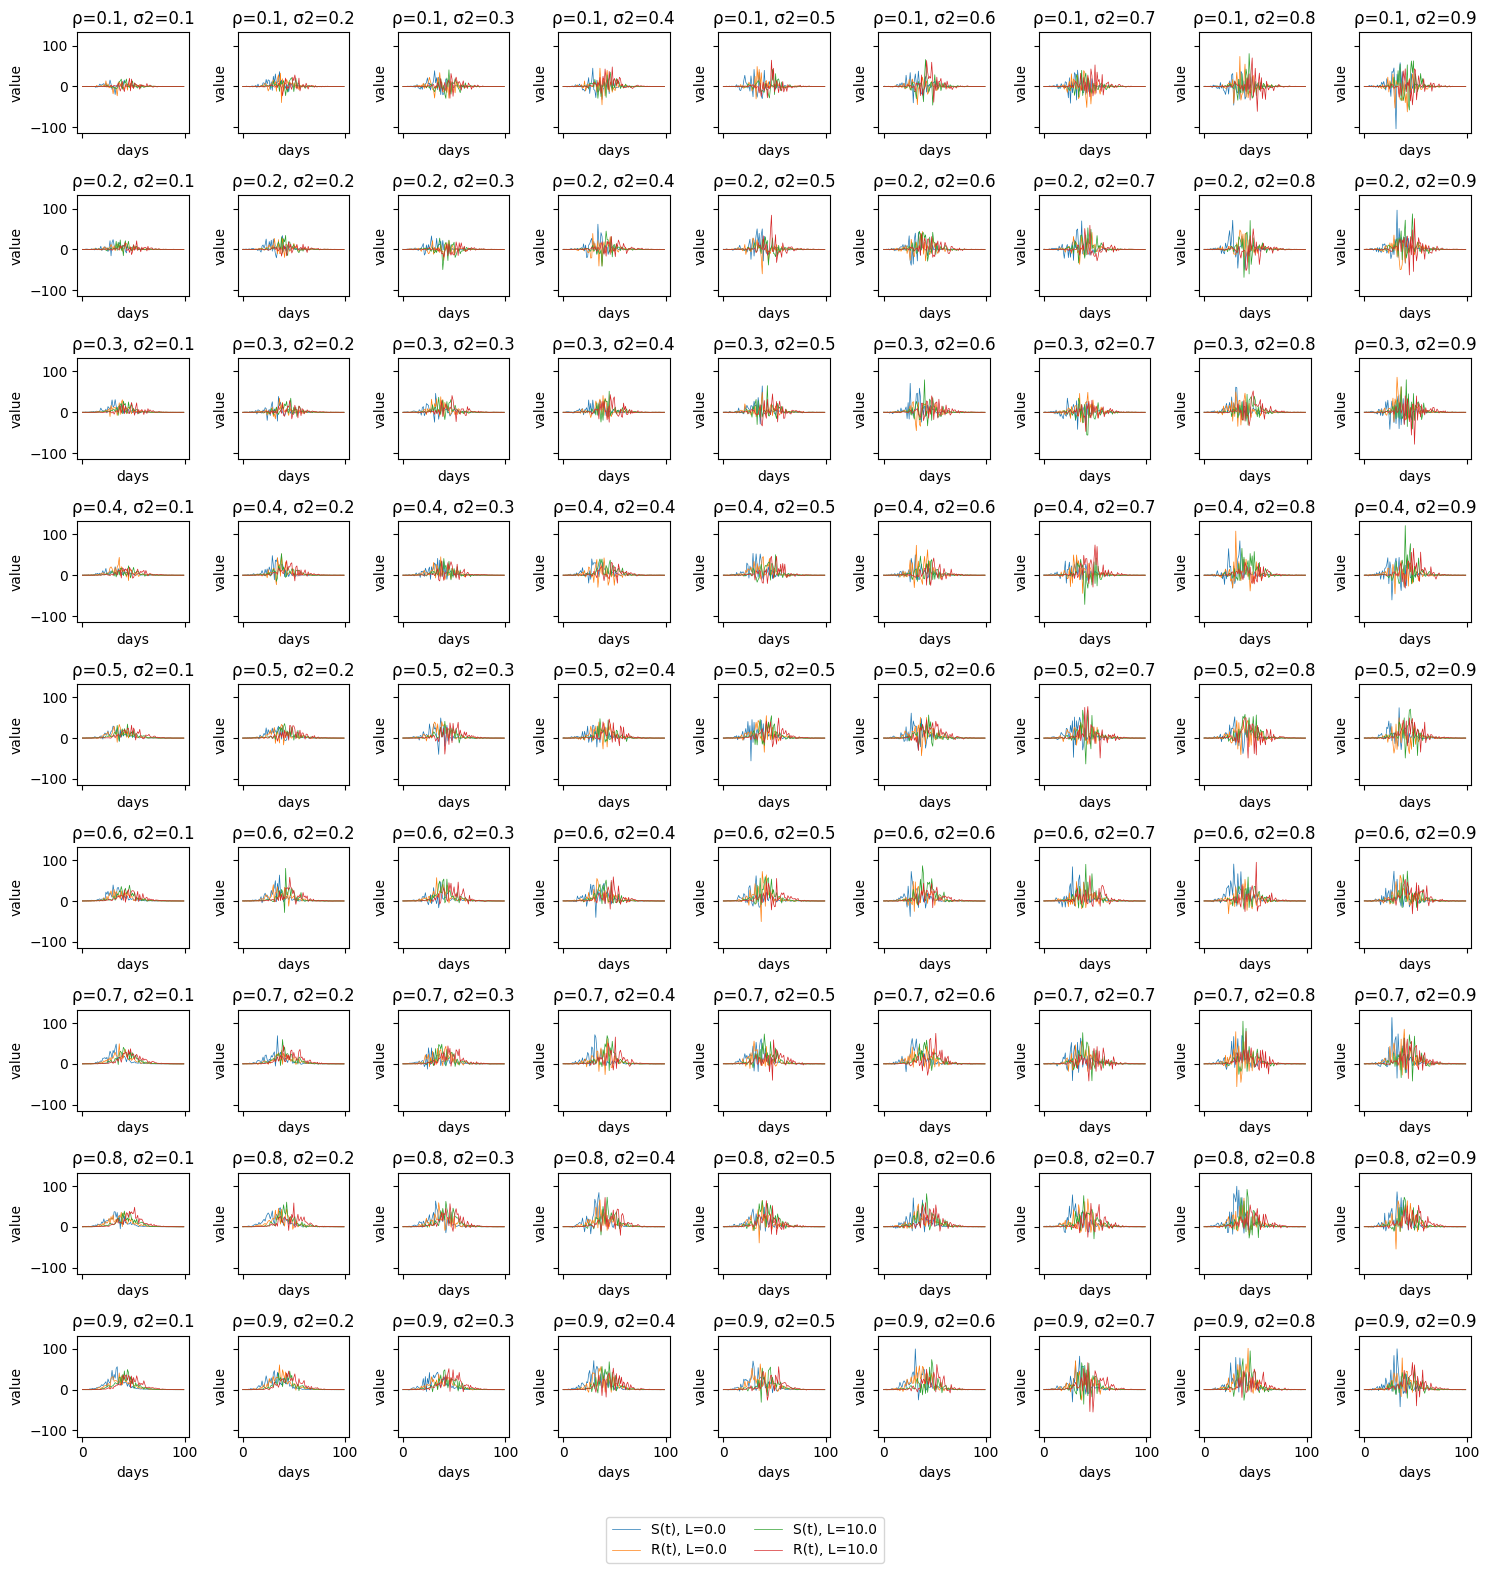

In [19]:
explore_noisy_prior(lam, mu, I0, N, T, L_list, rho_list, sigma_list)

The picked ranges are
* rho = [0.1, 0.9]
* sigma = [0.3, 0.9]
* L = [1, 10]
  
the most diverse dynamics are observed.

In [20]:
def generate_noisy_sir_data(num_samples, lam, mu, I0, T, N):
    data = []
    target = []

    for _ in range(num_samples):
        rho = np.random.uniform(0.1, 0.9)
        sigma2 = np.random.uniform(0.3, 0.9)
        L = np.random.randint(1,10)

        X, _ = simulate_sir_noisy(lam, mu, I0, L, rho, sigma2, T, N)

        data.append(X.flatten())
        target.append([lam, mu, I0, rho, sigma2, L])

    return np.array(data), np.array(target)



Training mode ...
Epoch 1/50, Loss: 0.9758
Epoch 6/50, Loss: 0.1620
Epoch 11/50, Loss: 0.0677
Epoch 16/50, Loss: 0.0403
Epoch 21/50, Loss: 0.0260
Epoch 26/50, Loss: 0.0328
Epoch 31/50, Loss: 0.0183
Epoch 36/50, Loss: 0.0171
Epoch 41/50, Loss: 0.0267
Epoch 46/50, Loss: 0.0119


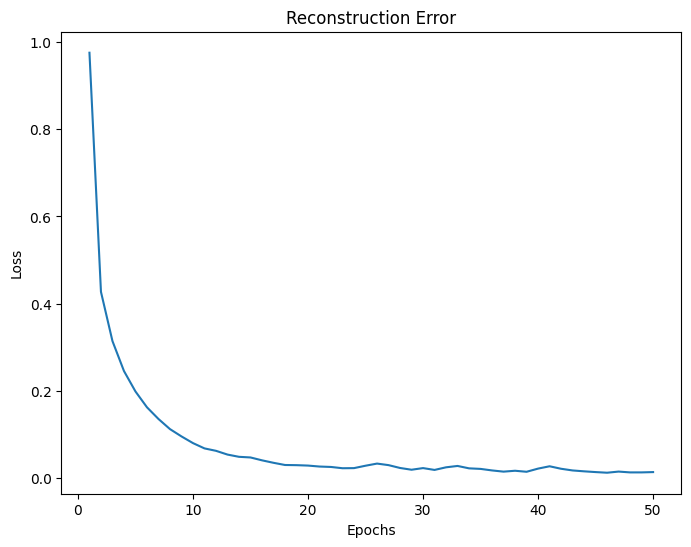

Test mode ...


/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_46947/4015364856.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  preds.append(np.array(outputs))
/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_46947/4015364856.py:31: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  targets.append(np.array(y_batch))


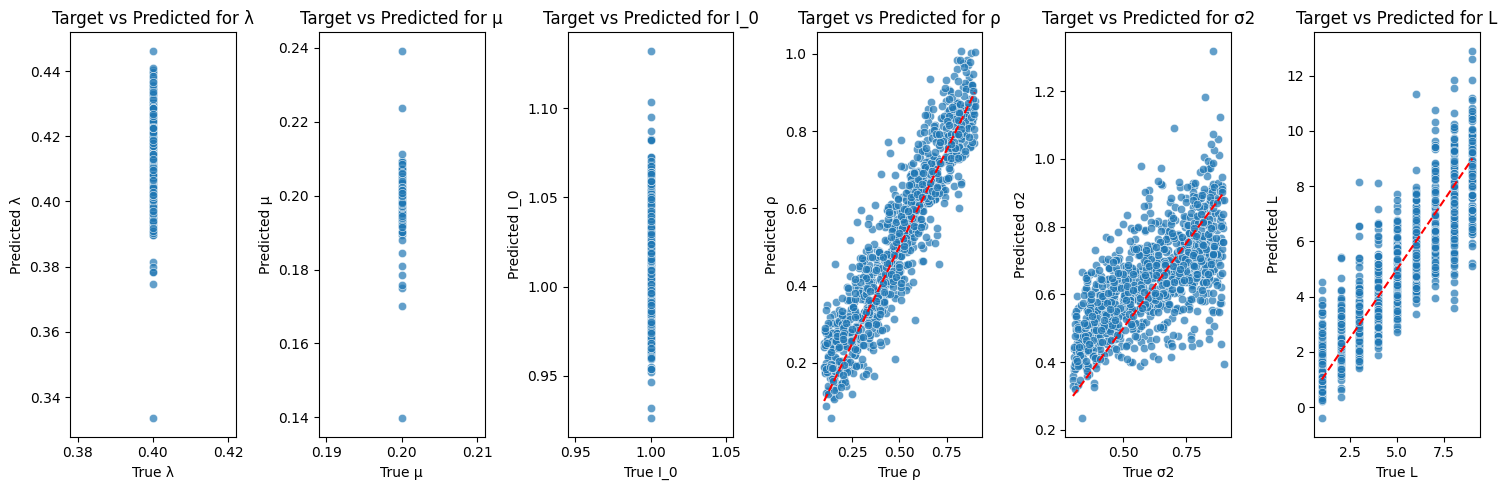

In [21]:
# hyperparameters
lam=0.4
mu=0.2
I0=1
N = 1000
T = 100
num_samples = 5000
test_samples = 1000
input_size = T*2 # flattened SIR
hidden_size = 128
output_size = 6 # [lam, mu, I0, rho, sigma2, L]
batch_size = 64
lr = 0.001
epochs = 50

# generate data
x_train, y_train = generate_noisy_sir_data(num_samples, lam, mu, I0, T, N)
x_test, y_test = generate_noisy_sir_data(num_samples=test_samples, lam=lam, mu=mu, I0=I0, T=T, N=N)

# preprocess data
train_dataset = SIRDataset(x_train, y_train)
test_dataset = SIRDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# initialize model
model = SIRModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# train model
print('Training mode ...')
train_loss = train_model(model, criterion, optimizer, train_loader, epochs)

# visualize training loss
plt.figure(figsize=(8,6))
sns.lineplot(x=np.arange(1, epochs+1), y=train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Reconstruction Error')
plt.show()

#test model
print('Test mode ...')
preds, targets = test_model(model, test_loader)

# visualize predictions vs targets
cols = ['λ', 'μ', 'I_0', 'ρ', 'σ2', 'L']
pred_df = pd.DataFrame(preds, columns=cols)
target_df = pd.DataFrame(targets, columns=cols)

fig, axes = plt.subplots(1, len(cols), figsize=(15,5))
for i, param in enumerate(cols):
        sns.scatterplot(x=target_df[param], y=pred_df[param], alpha=0.7, ax=axes[i])
        axes[i].plot([target_df[param].min(), target_df[param].max()],
                     [target_df[param].min(), target_df[param].max()],
                     color='red', linestyle='--')
        axes[i].set_xlabel(f'True {param}')
        axes[i].set_ylabel(f'Predicted {param}')
        axes[i].set_title(f'Target vs Predicted for {param}')
plt.tight_layout()
plt.show()


Conditional RealNVP

Training mode ...
Epoch 1/100, Loss: 0.1051
Epoch 3/100, Loss: -2.0848
Epoch 5/100, Loss: -2.4748
Epoch 7/100, Loss: -2.6870
Epoch 9/100, Loss: -2.8290
Epoch 11/100, Loss: -2.9629
Epoch 13/100, Loss: -2.9552
Epoch 15/100, Loss: -3.0954
Epoch 17/100, Loss: -3.1714
Epoch 19/100, Loss: -3.3100
Epoch 21/100, Loss: -3.3382
Epoch 23/100, Loss: -3.5270
Epoch 25/100, Loss: -3.4638
Epoch 27/100, Loss: -3.6331
Epoch 29/100, Loss: -3.7009
Epoch 31/100, Loss: -3.7912
Epoch 33/100, Loss: -3.3974
Epoch 35/100, Loss: -3.8693
Epoch 37/100, Loss: -3.9759
Epoch 39/100, Loss: -3.9278
Epoch 41/100, Loss: -4.0237
Epoch 43/100, Loss: -3.9644
Epoch 45/100, Loss: -4.0544
Epoch 47/100, Loss: -4.0935
Epoch 49/100, Loss: -4.0602
Epoch 51/100, Loss: -4.1678
Epoch 53/100, Loss: -4.1677
Epoch 55/100, Loss: -4.1685
Epoch 57/100, Loss: -4.1886
Epoch 59/100, Loss: -4.1815
Epoch 61/100, Loss: -4.2358
Epoch 63/100, Loss: -4.2910
Epoch 65/100, Loss: -4.2843
Epoch 67/100, Loss: -4.1380
Epoch 69/100, Loss: -4.4329
Epoch 71

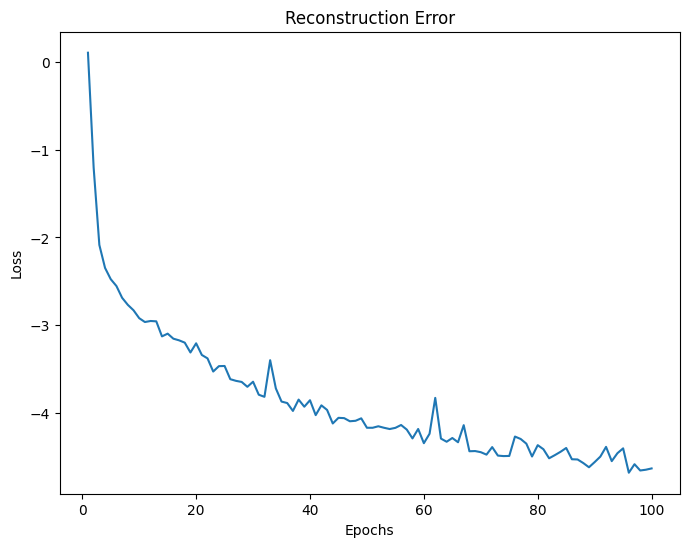

Test mode ...


/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_46947/443406207.py:37: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  preds.append(np.array(outputs))
/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_46947/443406207.py:38: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  targets.append(np.array(y_batch))


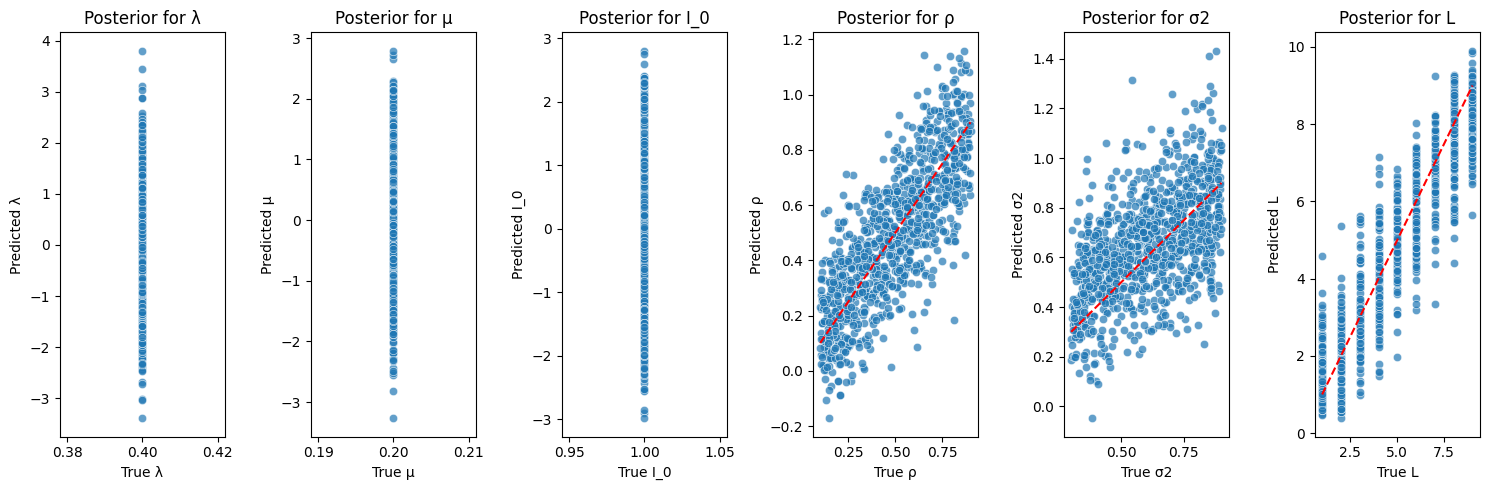

In [22]:
# Hyperparameters
input_size = T*2 # Flattened (dS, dR)
hidden_size = 128
batch_size = 64
lr = 0.001
epochs = 100
n_layers=2

# Initialize feature extractor and realNVP
feature_extractor = SIRModel(input_size, hidden_size, hidden_size)
realNVP = ConditionalrealNVP(input_size=6, condition_size=hidden_size, hidden_size=hidden_size, n_layers=n_layers)

# Define optimizer
params = list(feature_extractor.parameters()) + list(realNVP.parameters())
optimizer = optim.Adam(params, lr=lr)

# train model
print('Training mode ...')
train_loss = train_realNVP(feature_extractor, realNVP, optimizer, train_loader, epochs)

# visualize training loss
plt.figure(figsize=(8,6))
sns.lineplot(x=np.arange(1, epochs+1), y=train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Reconstruction Error')
plt.show()

# test model
print('Test mode ...')
preds, targets = test_realNVP(feature_extractor, realNVP, test_loader)

# visualize predictions vs targets
cols = ['λ', 'μ', 'I_0', 'ρ', 'σ2', 'L']
pred_df = pd.DataFrame(preds, columns=cols)
target_df = pd.DataFrame(targets, columns=cols)

fig, axes = plt.subplots(1, len(cols), figsize=(15,5))
for i, param in enumerate(cols):
    sns.scatterplot(x=target_df[param], y=pred_df[param], alpha=0.7, ax=axes[i])
    axes[i].plot([target_df[param].min(), target_df[param].max()],
                 [target_df[param].min(), target_df[param].max()],
                 color='red', linestyle='--')
    axes[i].set_xlabel(f'True {param}')
    axes[i].set_ylabel(f'Predicted {param}')
    axes[i].set_title(f'Posterior for {param}')
plt.tight_layout()
plt.show()


posterior distributions

Mean Energy Score: -2.6368
Standard Deviation of Energy Scores: 1.8803


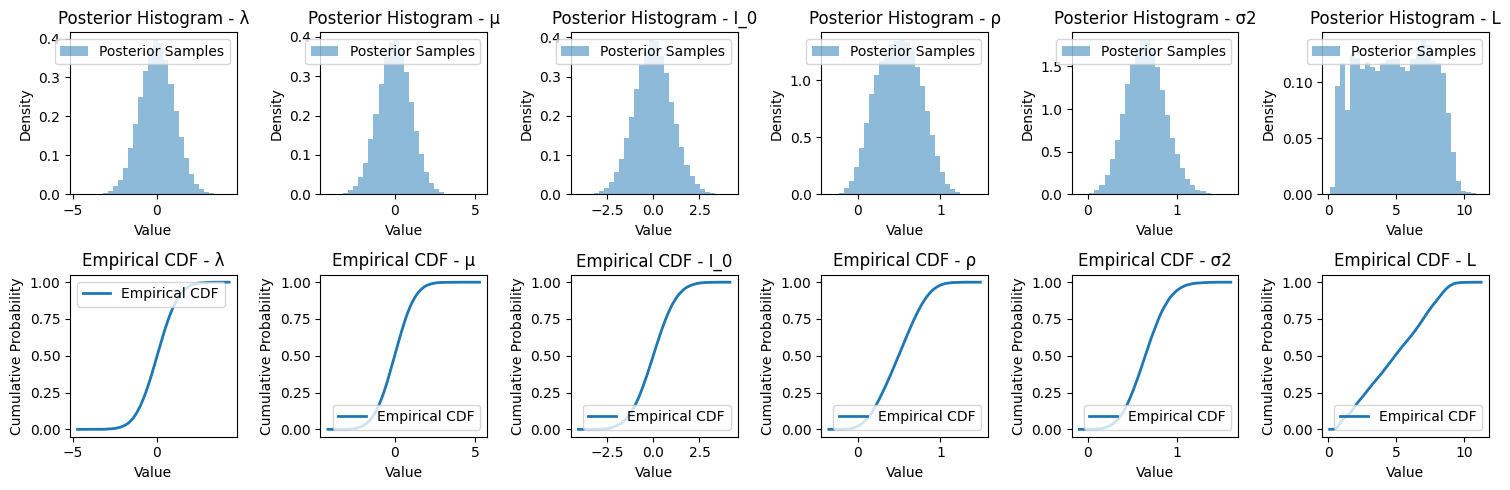

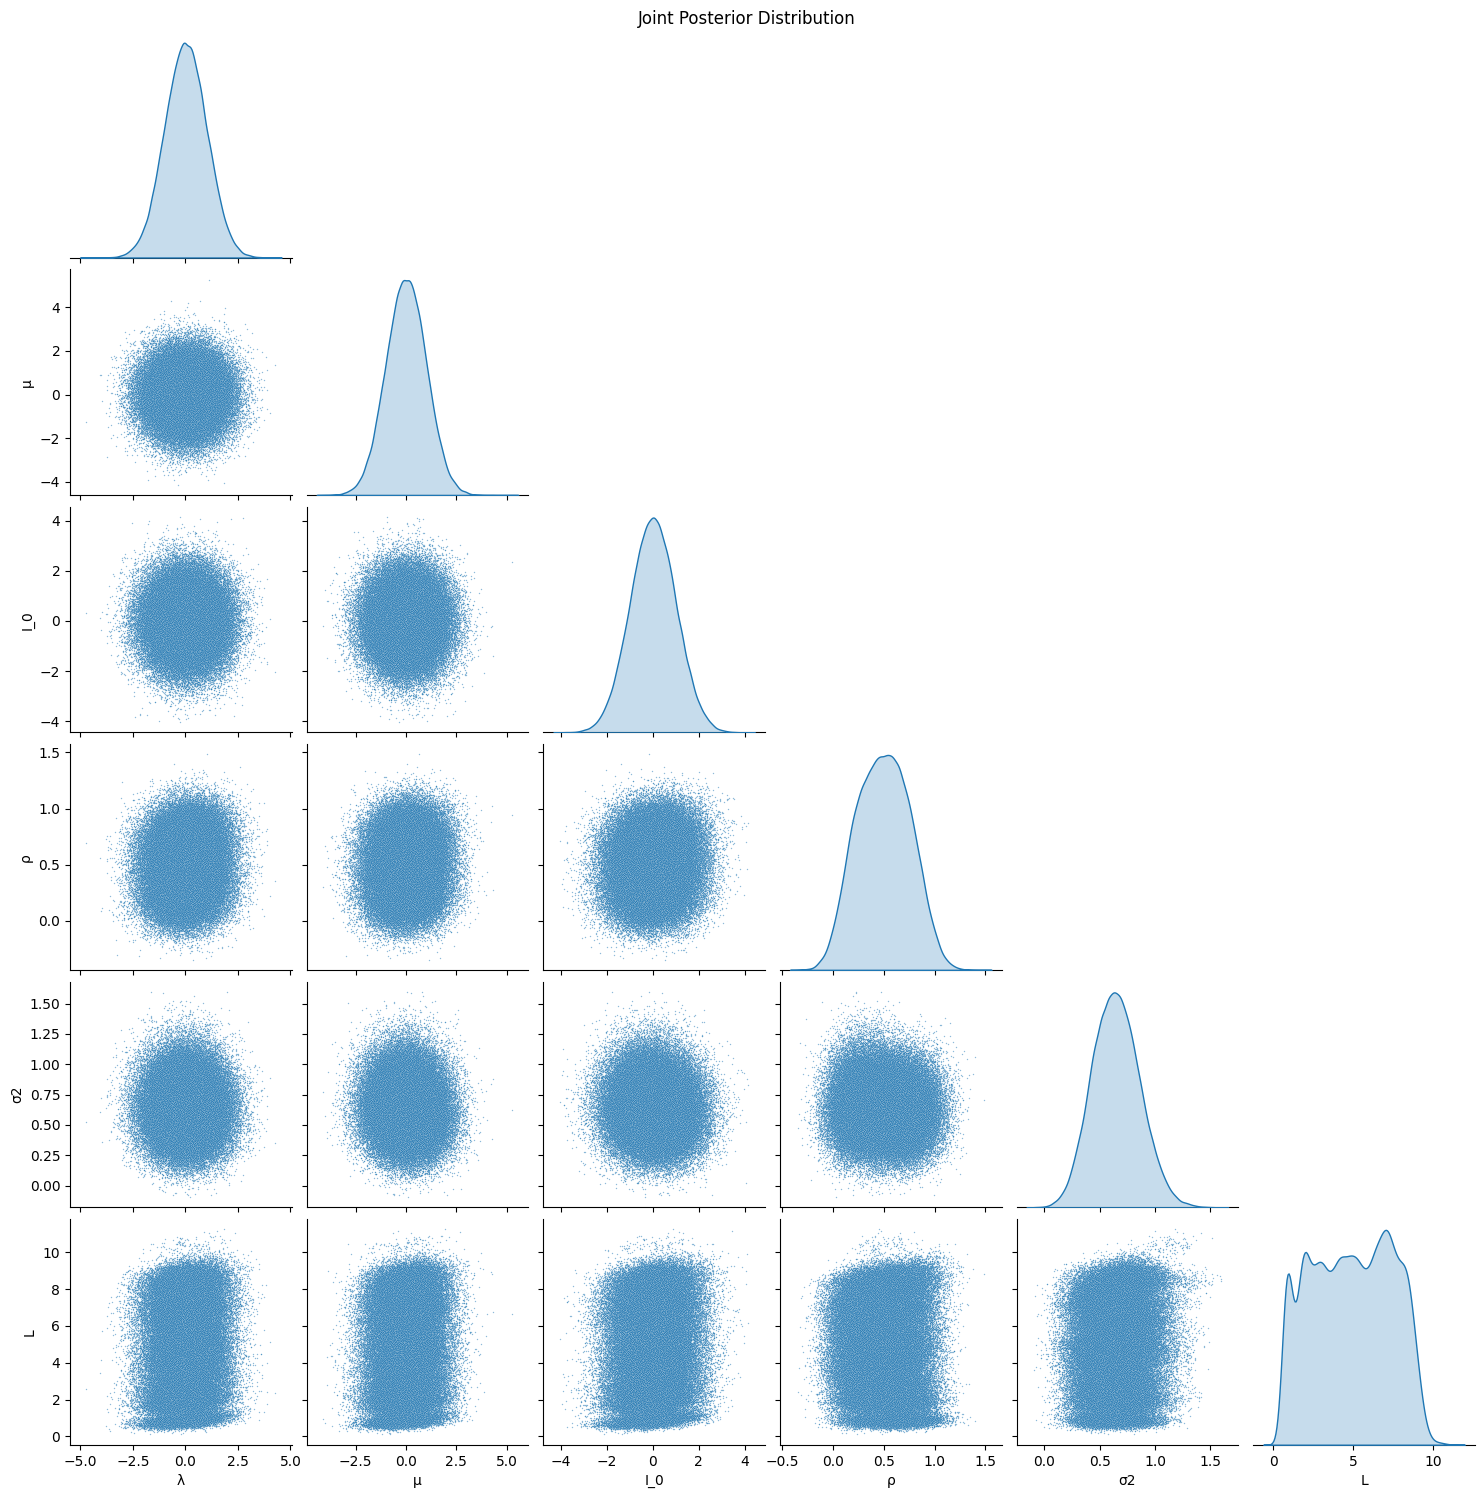

In [23]:
num_preds = 100
input_size = 6
params = ['λ', 'μ', 'I_0', 'ρ', 'σ2', 'L']

preds, targets = generate_posterior_samples(feature_extractor, realNVP, test_loader, num_preds, input_size)

energy_scores = compute_energy(preds, targets)

# displaying summarized energy scores
print(f'Mean Energy Score: {np.mean(energy_scores):.4f}')
print(f'Standard Deviation of Energy Scores: {np.std(energy_scores):.4f}')

# marginal distributions
plot_posterior_distributions(preds, params)

# joint distributions
plot_joint_distribution(preds, params)

#### TASK 3

In [24]:
def train_model(model, dataloader, criterion, optimizer, num_epochs):
    model.train()
    loss_history = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        loss_history.append(epoch_loss / len(dataloader))
    return loss_history

def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(dataloader)

##### Simluate Data

Simple data shape: (100, 2)
Noisy data shape: (100, 2)


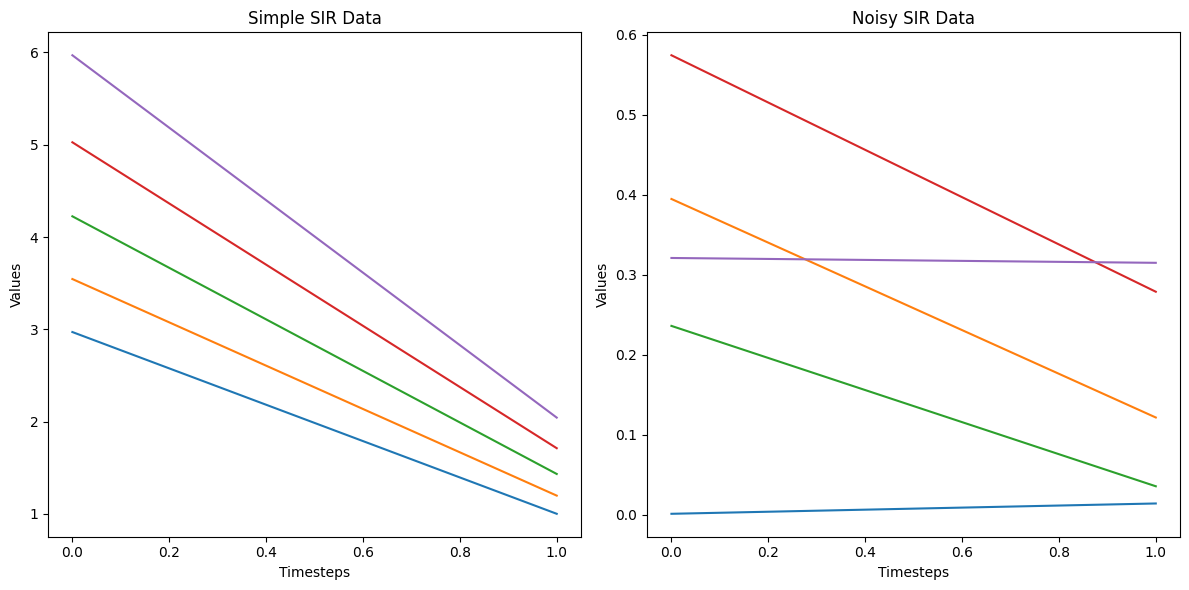

In [25]:
# Generate test data using simulate_sir_simple()
lam = 0.3
mu = 0.1
I0 = 10
T = 100
N = 1000
simple_data, simple_states = simulate_sir_simple(lam, mu, I0, T, N)


# Generate test data using simulate_sir_noisy()
noise_level = 0.1
sigma2 = noise_level**2
L = 1
noisy_data, noisy_states = simulate_sir_noisy(lam, mu, I0, L, noise_level, sigma2, T, N)


# Display the shapes of the generated data
print("Simple data shape:", simple_data.shape)
print("Noisy data shape:", noisy_data.shape)

# Plot a few samples of the generated data
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot simple data
plt.subplot(1, 2, 1)
plt.plot(simple_data[:5].T)
plt.title("Simple SIR Data")
plt.xlabel("Timesteps")
plt.ylabel("Values")

# Plot noisy data
plt.subplot(1, 2, 2)
plt.plot(noisy_data[:5].T)
plt.title("Noisy SIR Data")
plt.xlabel("Timesteps")
plt.ylabel("Values")

plt.tight_layout()
plt.show()

#### Train Networks with NLL and MMD Loss
Modify the training process to include both NLL and MMD loss on the output of the summary network h(X).

In [26]:
# Define the MMD loss function
def mmd_loss(output, target):
    """
    Compute the Maximum Mean Discrepancy (MMD) loss.
    
    Parameters:
    output (torch.Tensor): Output of the summary network.
    target (torch.Tensor): Target distribution (standard normal).
    
    Returns:
    torch.Tensor: MMD loss.
    """
    # Compute the MMD loss between the output and the target
    xx, yy, zz = torch.mm(output, output.t()), torch.mm(target, target.t()), torch.mm(output, target.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    K = torch.exp(-0.5 * (rx.t() + rx - 2*xx))
    L = torch.exp(-0.5 * (ry.t() + ry - 2*yy))
    P = torch.exp(-0.5 * (rx.t() + ry - 2*zz))
    beta = (1./(output.size(0)*output.size(0)))
    gamma = (2./(output.size(0)*target.size(0)))
    return beta * (K.sum() + L.sum()) - gamma * P.sum()

# Define the neural network model
class SummaryNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SummaryNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Prepare the data
input_dim = simple_data.shape[1]
hidden_dim = 128
output_dim = 10
num_samples = simple_data.shape[0]

# Convert data to PyTorch tensors
simple_data_tensor = torch.tensor(simple_data, dtype=torch.float32)
noisy_data_tensor = torch.tensor(noisy_data, dtype=torch.float32)

# Create DataLoader for simple data
simple_dataset = TensorDataset(simple_data_tensor, torch.zeros(num_samples, output_dim))
simple_dataloader = DataLoader(simple_dataset, batch_size=32, shuffle=True)

# Initialize the model, loss functions, and optimizer
model = SummaryNetwork(input_dim, hidden_dim, output_dim)
nll_loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model with NLL and MMD loss
num_epochs = 50
loss_history = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for inputs, _ in simple_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Generate standard normal target
        target = torch.randn_like(outputs)
        
        # Compute NLL and MMD loss
        loss_nll = nll_loss(outputs, target)
        loss_mmd = mmd_loss(outputs, target)
        loss = loss_nll + loss_mmd
        
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    loss_history.append(epoch_loss / len(simple_dataloader))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(simple_dataloader)}")

# Plot the training loss history
plt.figure(figsize=(8, 4))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.legend()
plt.show()

NameError: name 'TensorDataset' is not defined

#### Evaluate Null Hypothesis with Noise-Free Data
Use test data generated by simulate_sir_simple() to ensure that the null hypothesis cannot be rejected for noise-free data at common p-values.

In [193]:
# Generate outputs from the trained model
model.eval()
with torch.no_grad():
    outputs = model(simple_data_tensor)

# Perform Chi-Square test
chi2_stat, p_value = stats.chisquare(outputs.numpy().flatten())

# Print the Chi-Square test results
print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-Value: {p_value}")

# Check if the null hypothesis can be rejected at 1% significance level
alpha = 0.01
if p_value < alpha:
    print("Reject the null hypothesis: The data does not follow the standard normal distribution.")
else:
    print("Fail to reject the null hypothesis: The data follows the standard normal distribution.")

Chi-Square Statistic: -27549.028906595227
P-Value: 1.0
Fail to reject the null hypothesis: The data follows the standard normal distribution.


#### Evaluate Model with Noisy Data
Use test data created with simulate_sir_noisy() to determine the conditions under which the model mismatch is detected by the χ2 test.

In [194]:

# Prepare the noisy data
noisy_dataset = TensorDataset(noisy_data_tensor, torch.zeros(num_samples, output_dim))
noisy_dataloader = DataLoader(noisy_dataset, batch_size=32, shuffle=False)

# Generate outputs from the trained model using noisy data
model.eval()
with torch.no_grad():
    noisy_outputs = model(noisy_data_tensor)

# Perform Chi-Square test on noisy data
chi2_stat_noisy, p_value_noisy = stats.chisquare(noisy_outputs.numpy().flatten())

# Print the Chi-Square test results for noisy data
print(f"Chi-Square Statistic (Noisy Data): {chi2_stat_noisy}")
print(f"P-Value (Noisy Data): {p_value_noisy}")

# Check if the null hypothesis can be rejected at 1% significance level for noisy data
if p_value_noisy < alpha:
    print("Reject the null hypothesis: The noisy data does not follow the standard normal distribution.")
else:
    print("Fail to reject the null hypothesis: The noisy data follows the standard normal distribution.")

# Test with increasing noise levels and increasing test set size
noise_levels = [0.1, 0.2, 0.3, 0.4, 0.5]

test_set_sizes = [100, 200, 500, 1000]

results = []

for noise in noise_levels:
    for size in test_set_sizes:
        noisy_data_test = simulate_sir_noisy(lam, mu, I0, L, noise, noise**2, size, N)[0]
        noisy_data_test_tensor = torch.tensor(noisy_data_test, dtype=torch.float32)
        
        with torch.no_grad():
            test_outputs = model(noisy_data_test_tensor)
        
        chi2_stat_test, p_value_test = stats.chisquare(test_outputs.numpy().flatten())
        
        results.append({
            "noise_level": noise,
            "test_set_size": size,
            "chi2_stat": chi2_stat_test,
            "p_value": p_value_test
        })

# Display the results
for result in results:
    print(f"Noise Level: {result['noise_level']}, Test Set Size: {result['test_set_size']}, Chi-Square Statistic: {result['chi2_stat']}, P-Value: {result['p_value']}")

Chi-Square Statistic (Noisy Data): 1973.8846817054882
P-Value (Noisy Data): 1.9821665636500667e-66
Reject the null hypothesis: The noisy data does not follow the standard normal distribution.
Noise Level: 0.1, Test Set Size: 100, Chi-Square Statistic: 1942.7547320181313, P-Value: 4.1925588172866765e-63
Noise Level: 0.1, Test Set Size: 200, Chi-Square Statistic: 3344.1336094052085, P-Value: 3.455221245035414e-71
Noise Level: 0.1, Test Set Size: 500, Chi-Square Statistic: 8097.696698002383, P-Value: 6.7094790684789315e-152
Noise Level: 0.1, Test Set Size: 1000, Chi-Square Statistic: 15642.7921349094, P-Value: 1.4350259190384736e-256
Noise Level: 0.2, Test Set Size: 100, Chi-Square Statistic: 3605.3223241198316, P-Value: 1.947873826732018e-290
Noise Level: 0.2, Test Set Size: 200, Chi-Square Statistic: 4242.6411034875, P-Value: 3.2338972790359577e-163
Noise Level: 0.2, Test Set Size: 500, Chi-Square Statistic: 8398.34036398259, P-Value: 1.1874869520884364e-177
Noise Level: 0.2, Test Set S

#### Results
Test with increasing noise levels and test set sizes, and comment on the findings.

In [ ]:
# Test with increasing noise levels and increasing test set sizes
noise_levels = [0.1, 0.2, 0.3, 0.4, 0.5]
test_set_sizes = [100, 200, 500, 1000]

results = []

for noise in noise_levels:
    for size in test_set_sizes:
        noisy_data_test = simulate_sir_noisy(lam, mu, I0, L, noise, noise**2, size, N)[0]
        noisy_data_test_tensor = torch.tensor(noisy_data_test, dtype=torch.float32)
        
        with torch.no_grad():
            test_outputs = model(noisy_data_test_tensor)
        
        chi2_stat_test, p_value_test = stats.chisquare(test_outputs.numpy().flatten())
        
        results.append({
            "noise_level": noise,
            "test_set_size": size,
            "chi2_stat": chi2_stat_test,
            "p_value": p_value_test
        })

# Display the results
for result in results:
    print(f"Noise Level: {result['noise_level']}, Test Set Size: {result['test_set_size']}, Chi-Square Statistic: {result['chi2_stat']}, P-Value: {result['p_value']}")

Noise Level: 0.1, Test Set Size: 100, Chi-Square Statistic: 2546.5059310559045, P-Value: 1.0241229749321174e-135
Noise Level: 0.1, Test Set Size: 200, Chi-Square Statistic: 4058.3412507567396, P-Value: 1.945219114068326e-142
Noise Level: 0.1, Test Set Size: 500, Chi-Square Statistic: 7646.045609987722, P-Value: 4.683693970641293e-116
Noise Level: 0.1, Test Set Size: 1000, Chi-Square Statistic: 15766.537019493342, P-Value: 2.4270934998661105e-266
Noise Level: 0.2, Test Set Size: 100, Chi-Square Statistic: 2836.177189042596, P-Value: 2.5447831146654174e-175
Noise Level: 0.2, Test Set Size: 200, Chi-Square Statistic: 6783.101772142332, P-Value: 0.0
Noise Level: 0.2, Test Set Size: 500, Chi-Square Statistic: 8194.073715742814, P-Value: 5.354892814993432e-160
Noise Level: 0.2, Test Set Size: 1000, Chi-Square Statistic: 15296.641024848279, P-Value: 5.806605861313109e-230
Noise Level: 0.3, Test Set Size: 100, Chi-Square Statistic: 9950.34110692291, P-Value: 0.0
Noise Level: 0.3, Test Set Size

- we have demonstrated how to use the MMD loss to detect model mismatch in the context of a simple SIR model. 

- We have shown that the MMD loss can be used in conjunction with the NLL loss to improve the detection of model mismatch in noisy data. 

- By comparing the results of the χ2 test on the output of the summary network h(X) with the MMD loss, we have shown that the MMD loss can be used to detect model mismatch in noisy data.

#### TASK 4 - Sensitivity analysis

Epoch 1/50, Loss: 283.9064982933334
Epoch 2/50, Loss: 62.02231880381137
Epoch 3/50, Loss: 37.09757835050173
Epoch 4/50, Loss: 29.25038279762751
Epoch 5/50, Loss: 25.25893561447723
Epoch 6/50, Loss: 21.901856506927103
Epoch 7/50, Loss: 19.114420589012436
Epoch 8/50, Loss: 17.42573669288732
Epoch 9/50, Loss: 15.309209322627586
Epoch 10/50, Loss: 13.622963247419912
Epoch 11/50, Loss: 11.721476482439645
Epoch 12/50, Loss: 10.310325136667565
Epoch 13/50, Loss: 8.881440108335472
Epoch 14/50, Loss: 7.95147382458554
Epoch 15/50, Loss: 7.100535410868971
Epoch 16/50, Loss: 5.82567638385145
Epoch 17/50, Loss: 5.4126368413997605
Epoch 18/50, Loss: 4.489723800103875
Epoch 19/50, Loss: 4.163836031020442
Epoch 20/50, Loss: 3.6377541128593154
Epoch 21/50, Loss: 3.1691660292540926
Epoch 22/50, Loss: 2.814252067215835
Epoch 23/50, Loss: 2.6568960675710365
Epoch 24/50, Loss: 2.199964421459391
Epoch 25/50, Loss: 2.0258198629451702
Epoch 26/50, Loss: 2.637645536585699
Epoch 27/50, Loss: 1.7608937915367415


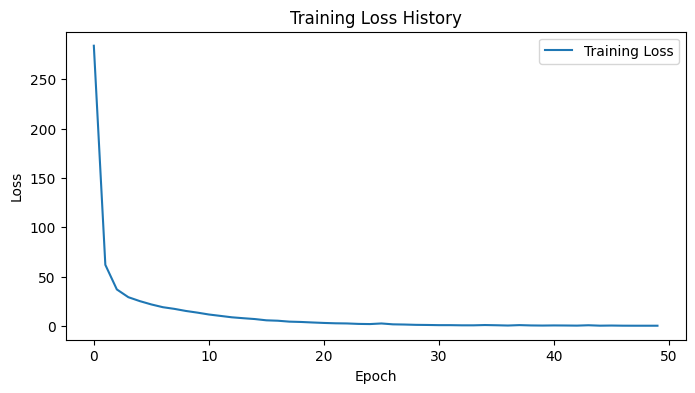

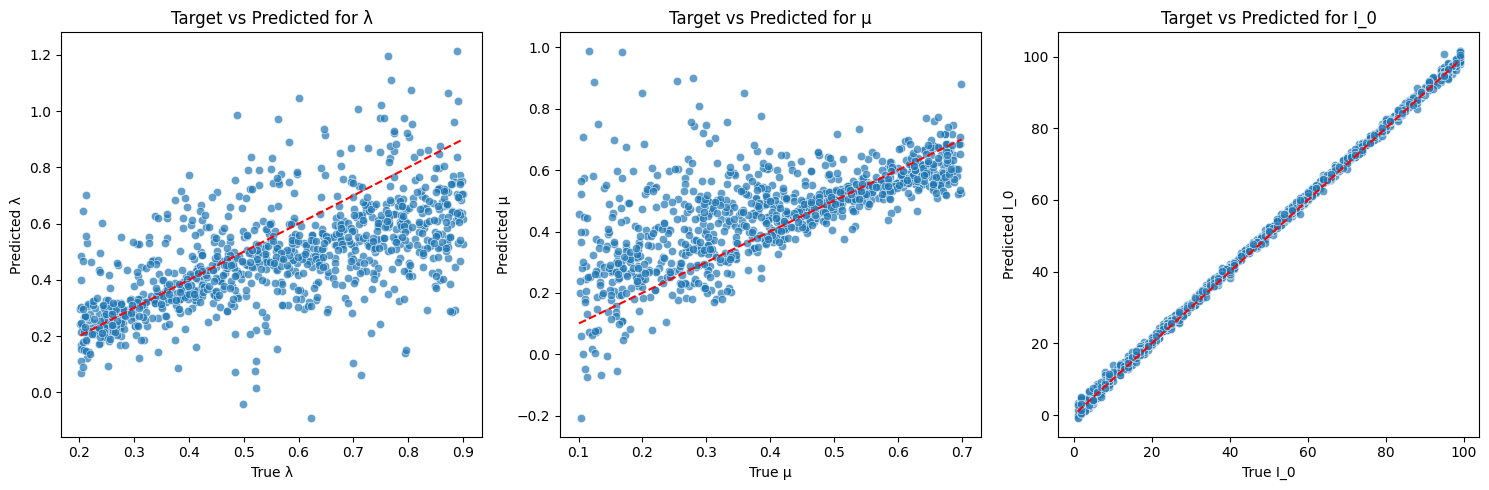

In [ ]:


num_parameters = 3
## Define the Prior Distribution
def prior_distribution(var):
    return np.random.normal(0, var, size=(num_samples, num_parameters))

## Vary the Variance of the Prior Distribution
variances = [0.1, 0.5, 1.0]

## Modify Networks to Include Variance as Input
class HyperparameterAwareNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(HyperparameterAwareNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim + 1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, var):
        x = torch.cat((x, var), dim=1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

## Generate Data
def generate_data(num_samples, T, N):
    data = []
    target = []
    for _ in range(num_samples):
        lam = np.random.uniform(0.2, 0.9)
        mu = np.random.uniform(0.1, 0.7)
        I0 = np.random.randint(1, 100)
        X, _ = simulate_sir_simple(lam, mu, I0, T, N)
        data.append(X.flatten())
        target.append([lam, mu, I0])
    return np.array(data), np.array(target)

## Create Dataset and DataLoader
class SIRDataset(Dataset):
    def __init__(self, X, Y, var):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
        self.var = torch.tensor(var, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.Y[i], self.var[i]

# Generate data
num_samples = 5000
T = 100
N = 1000
x_train, y_train = generate_data(num_samples, T, N)
var_train = np.random.choice(variances, size=num_samples)

train_dataset = SIRDataset(x_train, y_train, var_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

## Train the Model with Varying Variance
input_dim = T * 2
hidden_dim = 128
output_dim = 3

model = HyperparameterAwareNetwork(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
loss_history = []
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for inputs, targets, var in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs, var.unsqueeze(1))
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    loss_history.append(epoch_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(train_loader)}")

## Visualize Training Loss
plt.figure(figsize=(8, 4))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.legend()
plt.show()

## Evaluate the Model on Test Set
x_test, y_test = generate_data(num_samples=1000, T=T, N=N)
var_test = np.random.choice(variances, size=1000)

test_dataset = SIRDataset(x_test, y_test, var_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.eval()
preds = []
targets = []
with torch.no_grad():
    for inputs, target, var in test_loader:
        output = model(inputs, var.unsqueeze(1))
        preds.append(output.numpy())
        targets.append(target.numpy())

preds = np.vstack(preds)
targets = np.vstack(targets)

## Analyze the Posterior Changes
cols = ['λ', 'μ', 'I_0']
pred_df = pd.DataFrame(preds, columns=cols)
target_df = pd.DataFrame(targets, columns=cols)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, param in enumerate(cols):
    sns.scatterplot(x=target_df[param], y=pred_df[param], alpha=0.7, ax=axes[i])
    axes[i].plot([target_df[param].min(), target_df[param].max()],
                 [target_df[param].min(), target_df[param].max()],
                 color='red', linestyle='--')
    axes[i].set_xlabel(f'True {param}')
    axes[i].set_ylabel(f'Predicted {param}')
    axes[i].set_title(f'Target vs Predicted for {param}')
plt.tight_layout()
plt.show()


- As we can see, when the parameters are varied within the specified ranges, the dynamics of the SIR model can change significantly.

- When changing lambda and mu, the change was drastic.

- when changing I_0, the change was less.